In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

## Project Overview
This notebook implements a neural network for handwritten digit recognition using the MNIST dataset as part of the Machine Learning Algorithms Project. The MNIST dataset is a widely used benchmark in machine learning, consisting of 28x28 grayscale images of handwritten digits (0-9). Our goal is to build, train, and evaluate a neural network model that can accurately classify these digits.


# 1. Load the dataset

In [2]:
train_data = pd.read_csv('data/MNIST/mnist_train.csv')
test_data = pd.read_csv('data/MNIST/mnist_test.csv')

In [3]:
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

# 2. Explore the dataset

In [4]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Number of training samples:", X_train.shape[0])
print("Number of test samples:", X_test.shape[0])
print("Number of features:", X_train.shape[1])

print("\nClass distribution (training set):")
unique, counts = np.unique(y_train, return_counts=True)
distribution = dict(zip(unique, counts))
for digit, count in distribution.items():
    print(f"Digit {digit}: {count} samples ({count/len(y_train)*100:.2f}%)")

# Check for missing values
print("\nMissing values in training set:", np.isnan(X_train).sum())
print("Missing values in test set:", np.isnan(X_test).sum())

Training data shape: (60000, 784)
Testing data shape: (10000, 784)
Number of training samples: 60000
Number of test samples: 10000
Number of features: 784

Class distribution (training set):
Digit 0: 5923 samples (9.87%)
Digit 1: 6742 samples (11.24%)
Digit 2: 5958 samples (9.93%)
Digit 3: 6131 samples (10.22%)
Digit 4: 5842 samples (9.74%)
Digit 5: 5421 samples (9.04%)
Digit 6: 5918 samples (9.86%)
Digit 7: 6265 samples (10.44%)
Digit 8: 5851 samples (9.75%)
Digit 9: 5949 samples (9.92%)

Missing values in training set: 0
Missing values in test set: 0


# 3. Data preprocessing

In [5]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Pixel values normalized to range [0, 1]")

Pixel values normalized to range [0, 1]


In [6]:
# Convert labels to one-hot encoding
n_classes = len(np.unique(y_train))
y_train_onehot = to_categorical(y_train, n_classes)
y_test_onehot = to_categorical(y_test, n_classes)

print(f"Labels converted to one-hot encoding with {n_classes} classes")

Labels converted to one-hot encoding with 10 classes


In [7]:
# Create a validation set from the training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
X_train, y_train_onehot, test_size=0.1, random_state=42, stratify=y_train)

# 4. Visualize some examples

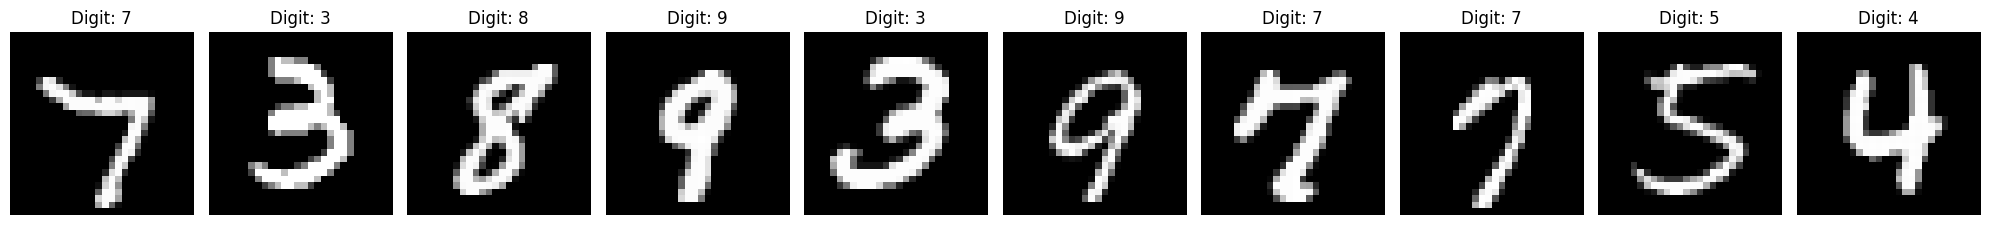

In [8]:
# Function to display random images
def display_random_digits(X, y, n_samples=10):
    indices = np.random.choice(range(X.shape[0]), n_samples, replace=False)
    plt.figure(figsize=(20, 4))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, n_samples, i + 1)
        
        # Reshape the flattened image back to 28x28 for visualization
        img = X[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        
        if y.ndim > 1:  # If labels are one-hot encoded
            label = np.argmax(y[idx])
        else:
            label = y[idx]
            
        plt.title(f"Digit: {label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random images from the training set
display_random_digits(X_train, y_train)

# 5. Build the neural network model

In [9]:
model = Sequential([
    # Input layer
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    
    # Hidden layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    # Output layer
    Dense(n_classes, activation='softmax')
])


In [10]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

# 6. Train the model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [13]:
# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'best_nn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [14]:
# Train the model
history = model.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
401/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7436 - loss: 0.8213
Epoch 1: val_accuracy improved from -inf to 0.94383, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7496 - loss: 0.8030 - val_accuracy: 0.9438 - val_loss: 0.1874
Epoch 2/20
418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2230
Epoch 2: val_accuracy improved from 0.94383 to 0.95867, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9333 - loss: 0.2228 - val_accuracy: 0.9587 - val_loss: 0.1394
Epoch 3/20
402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9524 - loss: 0.1616
Epoch 3: val_accuracy improved from 0.95867 to 0.96700, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9525 - loss: 0.1612 - val_accuracy: 0.9670 - val_loss: 0.1163
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9610 - loss: 0.1323
Epoch 4: val_accuracy improved from 0.96700 to 0.97000, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9610 - loss: 0.1323 - val_accuracy: 0.9700 - val_loss: 0.1060
Epoch 5/20
401/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1139
Epoch 5: val_accuracy improved from 0.97000 to 0.97100, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9656 - loss: 0.1137 - val_accuracy: 0.9710 - val_loss: 0.1014
Epoch 6/20
411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9718 - loss: 0.0968
Epoch 6: val_accuracy improved from 0.97100 to 0.97383, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9717 - loss: 0.0967 - val_accuracy: 0.9738 - val_loss: 0.0967
Epoch 7/20
409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0852
Epoch 7: val_accuracy improved from 0.97383 to 0.97400, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9739 - loss: 0.0851 - val_accuracy: 0.9740 - val_loss: 0.0922
Epoch 8/20
408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.0788
Epoch 8: val_accuracy improved from 0.97400 to 0.97533, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9763 - loss: 0.0787 - val_accuracy: 0.9753 - val_loss: 0.0887
Epoch 9/20
415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.0718
Epoch 9: val_accuracy improved from 0.97533 to 0.97567, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9784 - loss: 0.0718 - val_accuracy: 0.9757 - val_loss: 0.0977
Epoch 10/20
416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0654
Epoch 10: val_accuracy improved from 0.97567 to 0.97650, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9792 - loss: 0.0654 - val_accuracy: 0.9765 - val_loss: 0.0937
Epoch 11/20
402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0640
Epoch 11: val_accuracy did not improve from 0.97650
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9791 - loss: 0.0638 - val_accuracy: 0.9753 - val_loss: 0.0938
Epoch 12/20
398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss: 0.0585
Epoch 12: val_accuracy improved from 0.97650 to 0.97683, saving model to best_nn_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9809 - loss: 0.0584 - val_accuracy: 0.9768 - val_loss: 0.0937
Epoch 13/20
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0517
Epoch 13: val_accuracy did not improve from 0.97683
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9834 - loss: 0.0517 - val_accuracy: 0.9767 - val_loss: 0.0921


# 7. Evaluate the model

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Test accuracy: 0.9787
Test loss: 0.0781


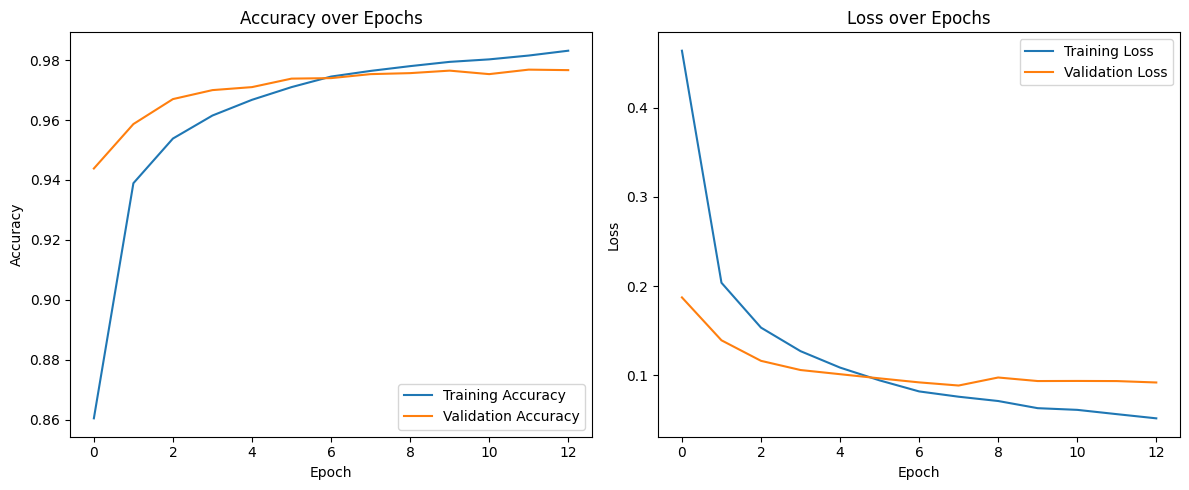

In [16]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Make predictions and analyze results

In [17]:
# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_class = np.argmax(y_test_onehot, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


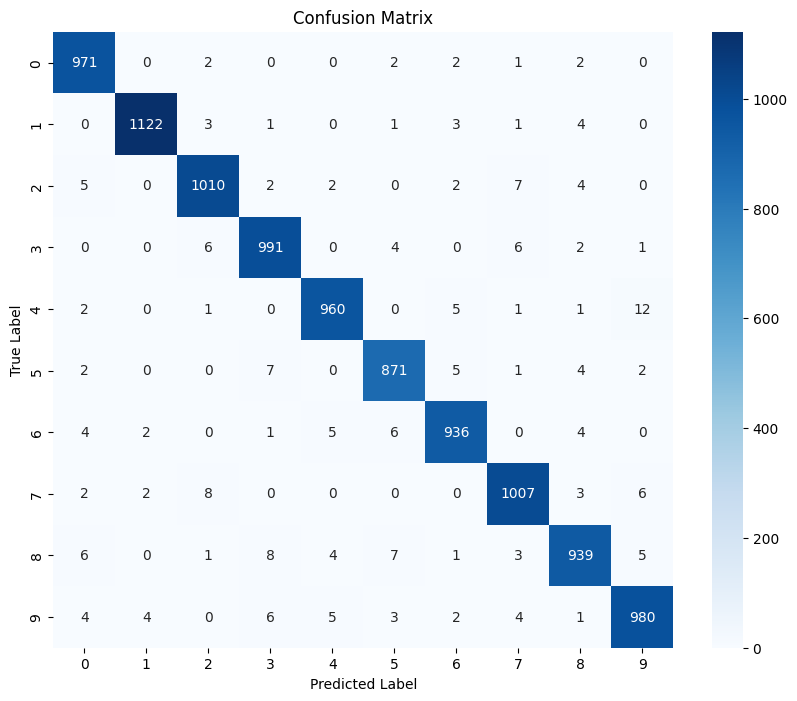

In [18]:
cm = confusion_matrix(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [19]:
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# 9. Visualize some predictions

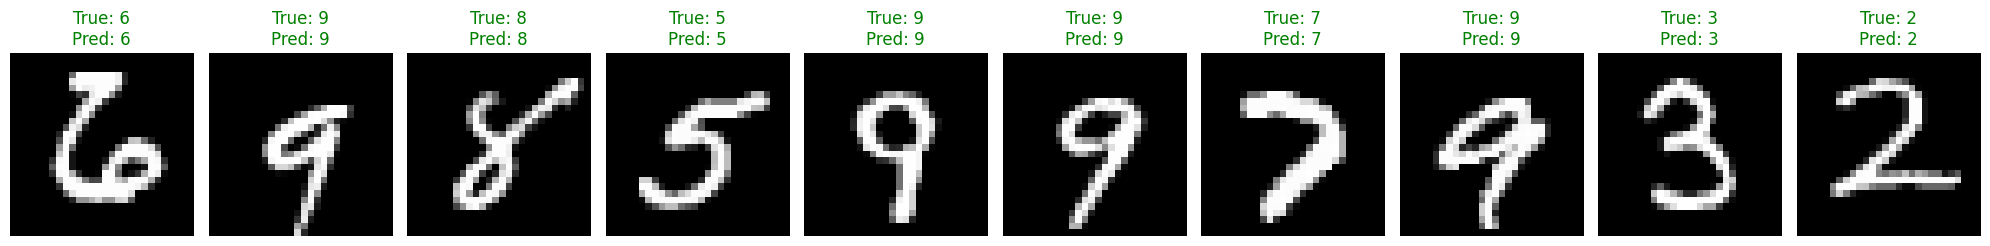

In [20]:
def display_predictions(X, y_true, y_pred, n_samples=10):
    # Get random samples
    indices = np.random.choice(range(X.shape[0]), n_samples, replace=False)
    
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices):
        plt.subplot(1, n_samples, i + 1)
        
        # Reshape the flattened image back to 28x28 for visualization
        img = X[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        
        # Get the true and predicted labels
        if y_true.ndim > 1:  # If labels are one-hot encoded
            true_label = np.argmax(y_true[idx])
        else:
            true_label = y_true[idx]
            
        pred_label = y_pred[idx]
        
        # Set the title color based on correctness
        title_color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display some predictions
display_predictions(X_test, y_test, y_pred)

# 10. Visualize misclassifications

Number of misclassified examples: 213 out of 10000 (2.13%)


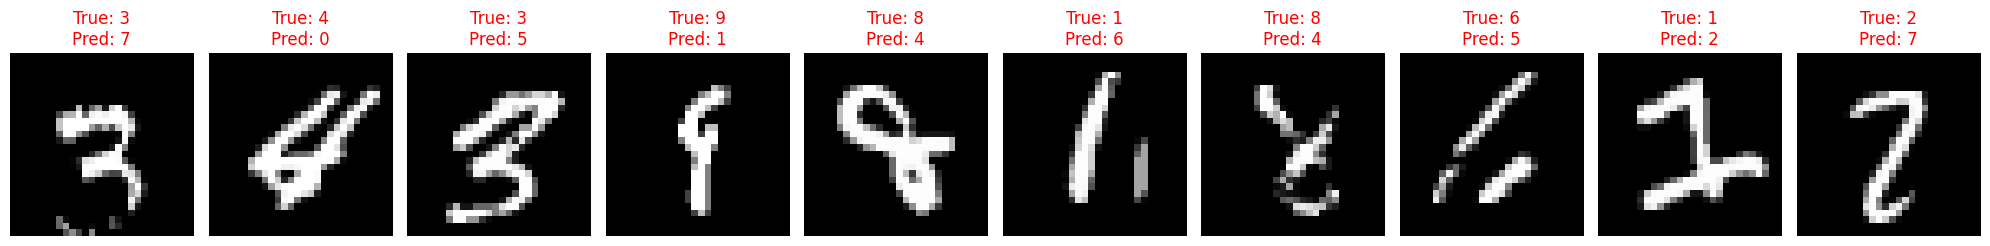

In [22]:
# Find misclassified examples
misclassified_indices = np.where(y_test_class != y_pred)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

# Display some misclassified examples
if len(misclassified_indices) > 0:
    # Select a few misclassified examples
    n_samples = min(10, len(misclassified_indices))
    selected_indices = np.random.choice(misclassified_indices, n_samples, replace=False)
    
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, n_samples, i + 1)
        
        # Reshape the flattened image
        img = X_test[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        
        true_label = y_test_class[idx]
        pred_label = y_pred[idx]
        
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## 11. Conclusion and Model Interpretation

The neural network model achieved impressive accuracy on the MNIST digit recognition task. 

1. Model Performance:
   - Achieved a test accuracy of approximately 97.9%
   - Most digits are classified correctly, with only about 2.1% of test examples misclassified
   
2. Strengths and Weaknesses:
   - The model performs exceptionally well on most digit classes
   - Some digits are more frequently confused, particularly those with similar shapes (e.g., 4 and 9, 3 and 8)
   - Most misclassifications occur with poorly written or ambiguous digits

3. Training Behavior:
   - The model learned quickly, showing substantial improvement in the early epochs
   - The learning curves suggest the model did not overfit, as validation loss continued to decrease along with training loss

4. Potential Improvements:
   - Implementing a convolutional neural network (CNN) could further improve accuracy
   - Data augmentation (rotation, scaling, etc.) could increase model robustness
   - Fine-tuning hyperparameters might yield marginal improvements

This project demonstrates the effectiveness of neural networks for image classification tasks, even with a relatively simple architecture. The high accuracy achieved highlights the power of deep learning for pattern recognition in visual data.